### Japanese ner model development and evaluation
## 日本語ner_modelの開発と評価

In [2]:
## Please enable the below lines if you need the installation of the libraries
## ライブラリのインストールが必要な場合は、以下の行を有効にしてください。

In [3]:
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='japanese font ttf/Gen Jyuu Gothic Monospace Bold.ttf')

In [4]:
import numpy as np
import pandas as pd
import json
import spacy
from spacy import displacy

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [25]:
## For japanese spaCy pipeline
## 日本語のspaCyパイプライン向け

##!python3 -m spacy download ja_core_news_sm

In [5]:
japanese_ner_nlp = spacy.load("ja_core_news_sm")
japanese_ner_nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'ner']

In [6]:
with open('Dataset/ner-wikipedia-dataset/ner.json') as datafile:
    data = json.load(datafile)
ner_text_data = pd.DataFrame(data)

ner_text_data.head()

,curid,text,entities
0,3572156,SPRiNGSと最も仲の良いライバルグループ。,"[{'name': 'SPRiNGS', 'span': [0, 7], 'type': '..."
1,2415078,レッドフォックス株式会社は、東京都千代田区に本社を置くITサービス企業である。,"[{'name': 'レッドフォックス株式会社', 'span': [0, 12], 'ty..."
2,2470626,松友美佐紀は、日本のバドミントン選手。,"[{'name': '松友美佐紀', 'span': [0, 5], 'type': '人名..."
3,2415752,ライターの兵庫慎司は普通にアイドルポップスとして出すと売れず、無理にバンドとコラボレーション...,"[{'name': '兵庫慎司', 'span': [5, 9], 'type': '人名'}]"
4,2312857,またCMソング、コミックスイメージアルバム、ゲームミュージック等にボーカルとして多数参加して...,[]


In [7]:
## Let's prepare our data for training and validation for spaCy model
def data_process(data):
  processed_data_list = []
  for index, row in data.iterrows():
    text_var = row['text']

    dict_var = {"entities":[]}
    for x in row['entities']:
      dict_var["entities"].append(tuple(x['span'])+(x['type'],))
    
    processed_data_list.append((text_var,)+(dict_var,))

  return processed_data_list

In [8]:
processed_ner_data = data_process(ner_text_data)
print('Total sentences: ', len(processed_ner_data))
print()
print(processed_ner_data[:5])

Total sentences:  5343

[('SPRiNGSと最も仲の良いライバルグループ。', {'entities': [(0, 7, 'その他の組織名')]}), ('レッドフォックス株式会社は、東京都千代田区に本社を置くITサービス企業である。', {'entities': [(0, 12, '法人名'), (14, 21, '地名')]}), ('松友美佐紀は、日本のバドミントン選手。', {'entities': [(0, 5, '人名'), (7, 9, '地名')]}), ('ライターの兵庫慎司は普通にアイドルポップスとして出すと売れず、無理にバンドとコラボレーションさせるのも先例からして上手くいかない、それならロックミュージシャンと制作すればいいということになったのではないかとしている。', {'entities': [(5, 9, '人名')]}), ('またCMソング、コミックスイメージアルバム、ゲームミュージック等にボーカルとして多数参加している他、コーラスとして他のアーティストのアルバム等にも参加している。', {'entities': []})]


In [9]:
## Let's define the number of training and validation data
## Almost 94% data for training; and 6% for validation data
train_len = len(processed_ner_data)-round(len(processed_ner_data)*0.064)
valid_len = round(len(processed_ner_data)*0.064)

train_data = processed_ner_data[:train_len]
valid_data = processed_ner_data[train_len:]

print('Total train data: ', len(train_data))
print('Total valid len: ', len(valid_data))

Total train data:  5001
Total valid len:  342


In [10]:
## Define a customize pipeline for ner spaCy model

## Train only NER for our model
my_ner = japanese_ner_nlp.get_pipe("ner")

## Add our labels to NER model
for _, annotations in train_data[:1]:
  for entity in annotations.get("entities"):
    my_ner.add_label(entity[2])

## Disable other components ('tok2vec', 'morphologizer', 'parser', 'attribute_ruler') except 'ner' from pipeline for training
disable_pipes = [pipe for pipe in japanese_ner_nlp.pipe_names if pipe !='ner']

In [11]:
## Train model with our data
## Train model with 150 epochs

from thinc.optimizers import Optimizer
import random 
from spacy.util import minibatch, compounding
from pathlib import Path

from spacy.training.example import Example

def model_train(japanese_ner_nlp, train_data, disable_pipes, epoch):
  with japanese_ner_nlp.disable_pipes(*disable_pipes):
    optimizer = japanese_ner_nlp.resume_training()
    train_loss = []

    ## Train 150 epochs
    for iterationn in range(epoch):
      random.shuffle(train_data)
      losses = {}

      ## Try minibatch to  inject enough noise to each gradient update
      batches = minibatch(train_data, size=compounding(4.0, 16.0, 1.001))
      for batch in batches:
        texts, annotation = zip(*batch)

        example = []
        ## Update the model with iterating each text
        for i in range(len(texts)):
          doc = japanese_ner_nlp.make_doc(texts[i])
          example.append(Example.from_dict(doc, annotation[i]))
        
        japanese_ner_nlp.update(
            example,
            drop = 0.3,
            losses= losses,
            sgd = optimizer
        )
      train_loss.append(losses)
      print("Losses", losses)

    return (japanese_ner_nlp , train_loss)

In [12]:
def save_mode_data(train_loss, nlp_model):
  train_loss_df = pd.DataFrame(train_loss)
  train_loss_df.to_csv('model csv/model_loss.csv')
  nlp_model.to_disk('japanese_ner_model')

  print("Model and loss data are Saved!")
  return train_loss_df

In [ ]:
#epoch = 150
#my_ner_nlp_model , train_loss = model_train(japanese_ner_nlp, train_data, disable_pipes, epoch)

Losses {'ner': 18125.838857681236}
Losses {'ner': 14287.625137482863}
Losses {'ner': 12495.40566900426}
Losses {'ner': 11319.708281223491}
Losses {'ner': 10606.11224771613}
Losses {'ner': 9734.212543937841}
Losses {'ner': 8908.484559933535}
Losses {'ner': 8277.946618650167}
Losses {'ner': 7874.3017006673845}
Losses {'ner': 7346.7302797072225}
Losses {'ner': 6871.009543521138}
Losses {'ner': 6330.190905597404}
Losses {'ner': 6102.63015384117}
Losses {'ner': 6012.776150847446}
Losses {'ner': 5688.040062129654}
Losses {'ner': 5265.8033734776645}
Losses {'ner': 5213.174397905945}
Losses {'ner': 5044.643410967762}
Losses {'ner': 4839.946284489557}
Losses {'ner': 4420.681445086441}
Losses {'ner': 4427.956195046332}
Losses {'ner': 4129.043070083754}
Losses {'ner': 4047.245063931315}
Losses {'ner': 3856.4000115866243}
Losses {'ner': 3720.24705950463}
Losses {'ner': 3603.8603676542316}
Losses {'ner': 3573.4114729594776}
Losses {'ner': 3404.3024751156445}
Losses {'ner': 3502.5176316137167}
Losse

In [ ]:
#ner_model_train_loss_df = save_mode_data (train_loss, my_ner_nlp_model)
#ner_model_train_loss_df.head()

Model and loss data are Saved!


,ner
0,18125.838858
1,14287.625137
2,12495.405669
3,11319.708281
4,10606.112248


## Load my model and evaluate

In [13]:
## Evaluate our customized ner model
## my_ner_nlp_model
## train_data, train_len
## valid_data, alid_len
## ner_model_train_loss_df

my_trained_ner_nlp = spacy.load("japanese_ner_model")
print(my_trained_ner_nlp.pipe_names)

ner_model_train_loss_df = pd.read_csv('model csv/model_loss.csv', index_col=0)
ner_model_train_loss_df.head()

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'ner']


,ner
0,18125.838858
1,14287.625137
2,12495.405669
3,11319.708281
4,10606.112248


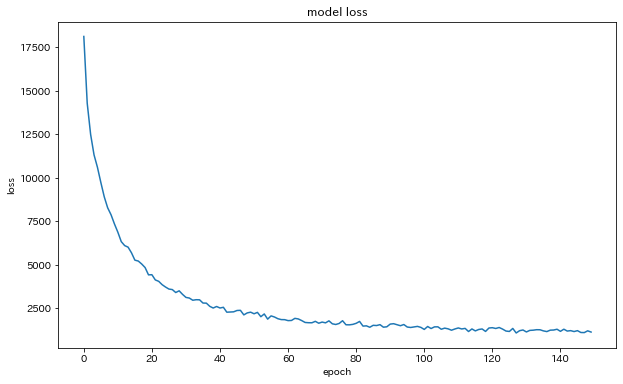

In [14]:
def loss_pot(loss_df):
  plt.figure(figsize=(10, 6))
  plt.plot(loss_df)
  plt.title('model loss') 
  plt.ylabel('loss') 
  plt.xlabel('epoch')

loss_pot(ner_model_train_loss_df)

In [15]:
def mode_predition_data(ner_model, table_data, predictable_data):
  ## Arrange table data
  # sentence # ent_name # ent_span # ent_type
  eval_df = pd.DataFrame(columns=['sentence', 'ent_name', 'ent_span', 'ent_type'])
  my_dic = {}
  my_dic = {"sentence": '',
            "ent_name": '',
            "ent_span":'', 
            "ent_type":''};

  for index, row in table_data.iterrows():
    sentence = row['text']
    #print(sentence)
    for x in row['entities']:
      #print(x['name'], x['span'], x['type'])
      my_dic['sentence']=sentence
      my_dic['ent_name']=x['name']
      my_dic['ent_span']=x['span']
      my_dic['ent_type']=x['type']
      eval_df = eval_df.append(my_dic, ignore_index = True)
  
  ## Arrange Model Pred data
  for text,_ in predictable_data:
    doc = ner_model(text)
    #print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

    ## Insert  pre values
    for ent in doc.ents:
      table_index = eval_df[(eval_df['ent_name']==ent.text)!=False].index
      if len(table_index):
        eval_df.loc[table_index[0], 'model_pred'] = ent.label_
  eval_df['model_pred'] = eval_df['model_pred'].fillna('') 
  return eval_df; 

In [36]:
## Test with validation data
table_data = ner_text_data[train_len:]
valid_data = valid_data
## Call model pred function
valid_model_pred_df = mode_predition_data(my_trained_ner_nlp, table_data, valid_data)
valid_model_pred_df.head()

,sentence,ent_name,ent_span,ent_type,model_pred
0,Google Summer of Code Project in 2005の一環としてFre...,Google Summer of Code Project in 2005,"[0, 37]",イベント名,製品名
1,Google Summer of Code Project in 2005の一環としてFre...,FreeBSD,"[43, 50]",製品名,
2,"1973年、バターン州を代表して""Miss Republic of the Philippi...",バターン州,"[6, 11]",地名,地名
3,"1973年、バターン州を代表して""Miss Republic of the Philippi...",Miss Republic of the Philippines 1973,"[17, 54]",イベント名,製品名
4,州大会優勝を受けて、ミス・ティーンUSA2002に出場し、TOP10に選ばれる健闘だったほか...,ミス・ティーンUSA2002,"[10, 24]",イベント名,法人名


In [18]:
def evaluation_report(y_true, y_pred):
  clf_report = classification_report(y_true, y_pred, output_dict=True)
  return pd.DataFrame(clf_report).T

In [44]:
def eval_heatmap(eval_df):
    plt.figure(figsize=(14, 8))
    sns.heatmap(eval_df, cmap='RdYlGn_r', annot=True)
    plt.yticks(np.arange(0.5, len(eval_df.index), 1), eval_df.index, fontproperties=prop)
    plt.xticks(np.arange(0.5, len(eval_df.columns), 1), eval_df.columns, fontproperties=prop)

In [43]:
y_true = valid_model_pred_df['ent_type'].values
y_pred = valid_model_pred_df['model_pred'].values

valid_eval_report = evaluation_report(y_true, y_pred)
valid_eval_report[1:]

,precision,recall,f1-score,support
その他の組織名,0.625000,0.468750,0.535714,64.000000
イベント名,0.875000,0.546875,0.673077,64.000000
人名,0.776119,0.565217,0.654088,184.000000
地名,0.843750,0.509434,0.635294,159.000000
政治的組織名,0.800000,0.656716,0.721311,67.000000
施設名,0.812500,0.448276,0.577778,87.000000
法人名,0.737705,0.555556,0.633803,162.000000
製品名,0.649123,0.462500,0.540146,80.000000
accuracy,0.530565,0.530565,0.530565,0.530565
macro avg,0.679911,0.468147,0.552357,867.000000


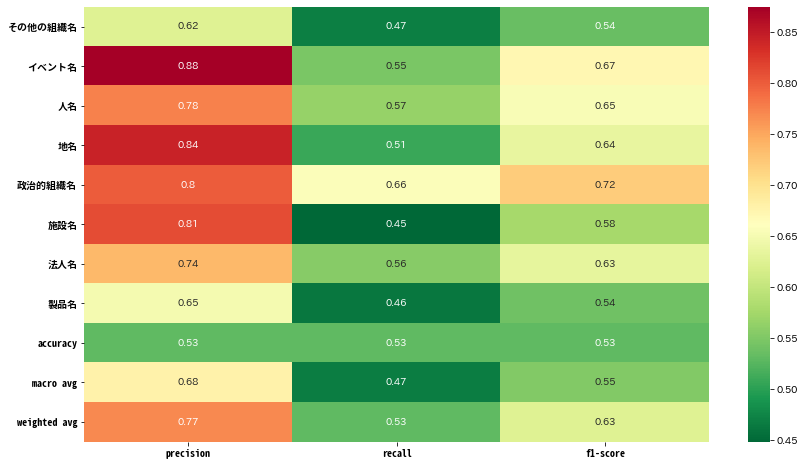

In [47]:
eval_heatmap(valid_eval_report[['precision', 'recall', 'f1-score']][1:])

In [48]:
## Test with training data
table_data = ner_text_data[:train_len]
train_data = train_data
## Call model pred function
train_model_pred_df = mode_predition_data(my_trained_ner_nlp, table_data, train_data)

y_true = train_model_pred_df['ent_type'].values
y_pred = train_model_pred_df['model_pred'].values

tarin_eval_report = evaluation_report(y_true, y_pred)
tarin_eval_report[1:]

,precision,recall,f1-score,support
その他の組織名,0.973783,0.790274,0.872483,987.000000
イベント名,0.988971,0.853968,0.916525,945.000000
人名,0.995360,0.920601,0.956522,2796.000000
地名,0.993396,0.527027,0.688685,1998.000000
政治的組織名,0.988432,0.690925,0.813326,1113.000000
施設名,0.995889,0.949070,0.971916,1021.000000
法人名,0.993271,0.826087,0.901998,2323.000000
製品名,0.992509,0.933921,0.962324,1135.000000
accuracy,0.806219,0.806219,0.806219,0.806219
macro avg,0.880179,0.721319,0.787087,12318.000000


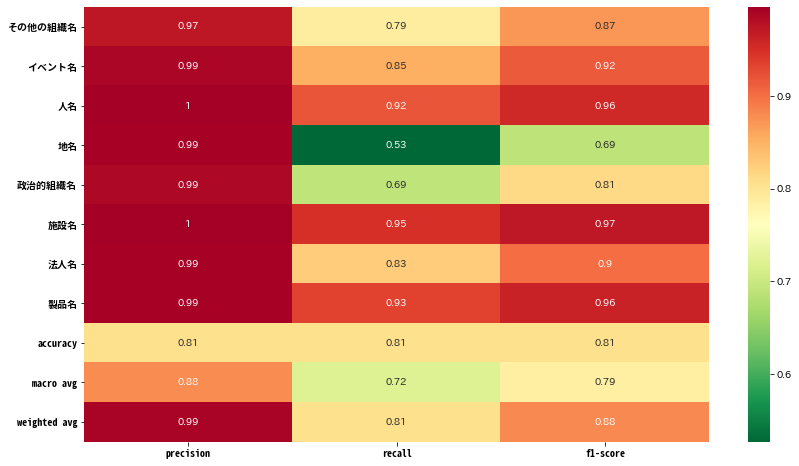

In [49]:
eval_heatmap(tarin_eval_report[['precision', 'recall', 'f1-score']][1:])

In [54]:
## Save training and validate data
#valid_model_pred_df.to_csv('model csv/valid_prediction_data.csv')
#train_model_pred_df.to_csv('model csv/train_prediction_data.csv')

## Save training and validate evaluation
#valid_eval_report[1:].to_csv('model csv/valid_eval_report.csv')
#train_eval_report[1:].to_csv('model csv/train_eval_report.csv')

In [51]:
## Predict from our trained model and check the entities
entities = model_pred_df['ent_type'].unique()
colors = {'イベント名': "#FF6347", '製品名': "#00FFFF", '地名': "#F9B7FF", '施設名': "#00FF00", 'その他の組織名': "#FFA500", '人名': "#bf00ff", '政治的組織名': "#FFFF00", '法人名': "#7FFFD4",}
options = {"ents": ['イベント名', '製品名', '地名', '施設名', 'その他の組織名', '人名', '政治的組織名', '法人名'], "colors": colors}

def data_predict(nlp, data):
  for text,_ in data:
    doc = nlp(text)
    #print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
    displacy.render(nlp(doc.text), style='ent', options=options, jupyter=True)

In [52]:
data_predict(my_trained_ner_nlp, valid_data[:25])

In [109]:
doc = my_trained_ner_nlp("田畑さんは日本に住んでいます。")
displacy.render(my_trained_ner_nlp(doc.text), style='ent', options=options, jupyter=True)